In [2]:
#!pip install git+https://github.com/Potatoasad/GaussianNoiseGenerator

# Generate LIGO Noise

In [19]:
import ringdown
from ringdb import Database
import matplotlib.pyplot as plt

In [13]:
db = Database("./Data")
db.initialize()
event = db.event("GW150914")

h1 = event.strain()["H1"]

In [44]:
myacf = h1.condition(ds=4, digital_filter=True).get_acf()

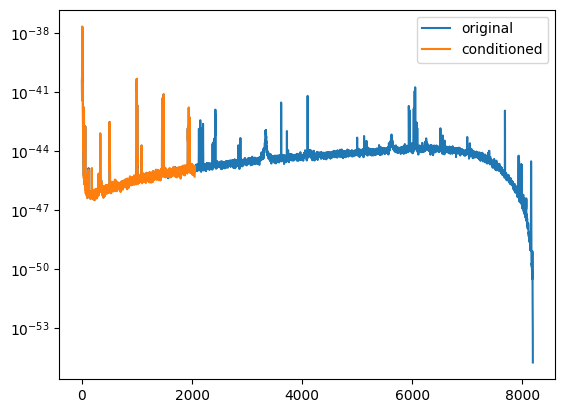

In [45]:
h1.get_psd(nperseg=h1.fsamp).plot(label='original')

myacf.to_psd().plot(label='conditioned')
plt.legend()
plt.yscale('log')

In [53]:
from GaussianNoiseGenerator import GaussianNoise
import numpy as np

In [75]:
GN = GaussianNoise(myacf.values, times=myacf.index)
GN.compute_cholesky_blocks()

In [76]:
ns = GN.cholesky @ np.random.normal(0,1,len(myacf.index))

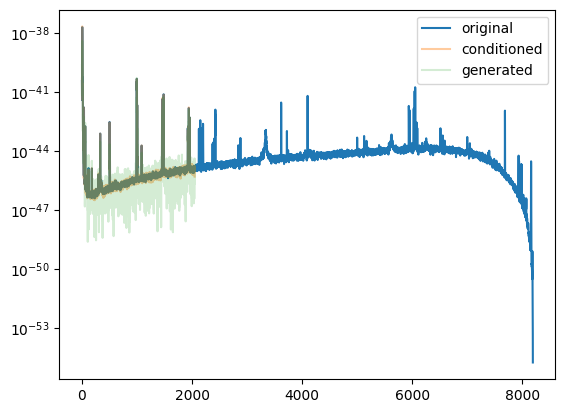

In [77]:
h1.get_psd(nperseg=h1.fsamp).plot(label='original')

myacf.to_psd().plot(label='conditioned', alpha=0.4)
plt.yscale('log')

ringdown.Data(ns, index=myacf.index).get_psd().plot(alpha=0.2, label='generated')
plt.legend()

plt.show()

In [83]:
fsamp = myacf.fsamp
duration = 32
t0 = 0

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))
epoch = t0

time = np.arange(tlen)*delta_t + epoch

long_noise = GN.generate(duration=duration, start_time=t0)


generated_noise = ringdown.Data(long_noise, index=time)

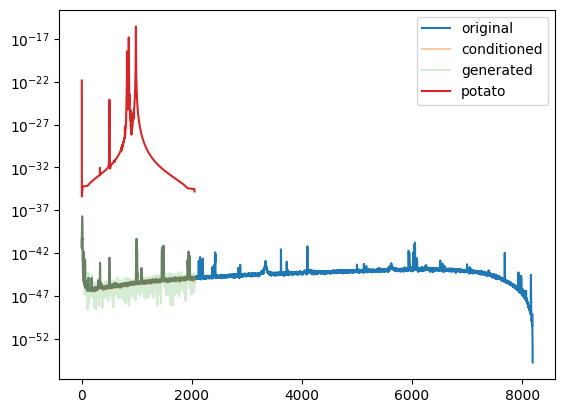

In [86]:
h1.get_psd(nperseg=h1.fsamp).plot(label='original')

myacf.to_psd().plot(label='conditioned', alpha=0.4)

ringdown.Data(ns, index=myacf.index).get_psd().plot(alpha=0.2, label='generated')

generated_noise.get_psd().plot(label='potato')


plt.yscale('log')
plt.legend()

plt.show()

<AxesSubplot: >

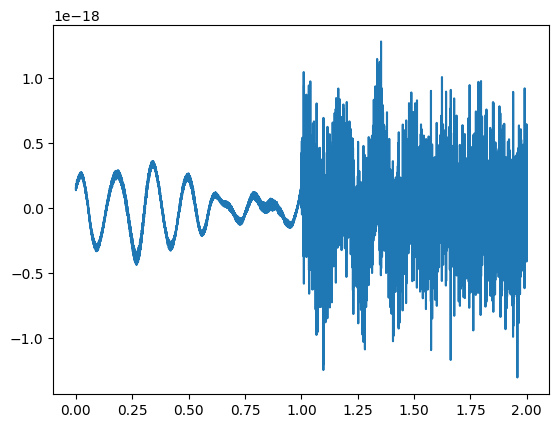

In [90]:
generated_noise[0:2].plot()

In [92]:
GN.cholesky @ GN.cholesky.transpose()

array([[ 2.80663925e-35,  1.62749242e-36,  1.36634427e-36, ...,
         9.50612886e-41,  7.79572595e-41,  1.46807385e-40],
       [ 1.62749242e-36,  3.27239808e-37,  3.06743130e-37, ...,
         4.74037289e-42,  1.60774633e-41,  2.66136365e-42],
       [ 1.36634427e-36,  3.06743130e-37,  3.72716127e-37, ...,
        -2.60839022e-42,  7.00760751e-42,  1.27874941e-41],
       ...,
       [ 9.50612886e-41,  4.74037289e-42, -2.60839022e-42, ...,
         9.47188525e-43, -4.80314917e-43,  9.56091119e-44],
       [ 7.79572595e-41,  1.60774633e-41,  7.00760751e-42, ...,
        -4.80314917e-43,  8.21270353e-43, -2.89771789e-43],
       [ 1.46807385e-40,  2.66136365e-42,  1.27874941e-41, ...,
         9.56091119e-44, -2.89771789e-43,  4.36824280e-43]])

In [99]:
import numpy as np
import scipy.linalg as sl
import scipy as sp

"""
This class implements a Gaussain Noise Generator
"""
class GaussianNoise:
	def __init__(self, acf, times=None, dt=None, sample_duration=None):
		self._acf = acf
		self._times = times
		self._cholesky = None #Upper cholesky decomposition

		"""
		Generates the time variable if needed, uses the convention:
		times = np.arange(0, duration, dt)
		"""
		self._dt = dt
		self._sample_duration = sample_duration
		if self._times is None:
			if (self._dt is not None) and (self._sample_duration is not None):
				self._times = np.arange(0.0, self._sample_duration, self._dt)
			else:
				raise ValueError("Need either times or dt and duration")

		self.N = len(self.times)

		"""
		Work for parts of matrix
		"""
		self._cov = None
		self.S11 = None
		self.S12 = None
		self.S21 = None
		self.S22 = None
		self.GeneratorRowMatrix = None

		self.NewVariance = None
		self.NewStd = None

	@property
	def acf(self):
		return self._acf

	@property
	def dt(self):
		return (self._dt) or (self._times[1]-self._times[0])

	@property
	def sample_duration(self):
		return (self._sample_duration) or (self._times[-1] - self._times[0] + self.dt)

	@property
	def times(self):
		return self._times

	@property
	def matrix(self):
	    return sl.toeplitz(self.acf)

	@property
	def cholesky(self):
	    if getattr(self, '_cholesky', None) is None:
	        self._cholesky = sl.cholesky(self.matrix)
	    return self._cholesky

	def compute_cholesky_blocks(self):
		n = self.N
		self._cov = self.cholesky @ self.cholesky.T

		self.S11 = self._cov[0:(n-1), 0:(n-1)]
		self.S12 = self._cov[n-1    , 0:(n-1)]
		self.S21 = self._cov[0:(n-1), n-1    ]
		self.S22 = self._cov[n-1    , n-1    ]

		self.GeneratorRowMatrix = self.S12.T @ sl.inv(self.S11)

		self.NewVariance = self.GeneratorRowMatrix @ self.S12
		self.NewStd = np.sqrt(self.NewVariance)

	def NewMean(self, past):
		return np.dot(self.GeneratorRowMatrix, past)

	def GenerateNext(self, past):
		return self.NewMean(past) + self.NewStd*np.random.randn()

	def generate(self, duration, start_time = 0.0):
		# New Time values:
		new_times = np.arange(start_time, duration + start_time, self.dt)
		new_noise = np.zeros_like(new_times)

		# Generate first samples
		L = self.cholesky
		x_std = np.random.normal(0, 1, self.times.shape)
		x_corr =  x_std @ L

		new_noise[0:len(x_corr)] = x_corr

		for j,t in enumerate(new_times[len(x_corr)::]):
			i = len(x_corr) + j
			past = new_noise[j:(i-1)]
			new_noise[i] = self.GenerateNext(past)

		return new_noise

In [94]:
GaussianNoise

__main__.GaussianNoise

In [96]:
fsamp = myacf.fsamp
duration = 32
t0 = 0

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))
epoch = t0

time = np.arange(tlen)*delta_t + epoch

long_noise = GN.generate(duration=duration, start_time=t0)


generated_noise = ringdown.Data(long_noise, index=time)

<AxesSubplot: >

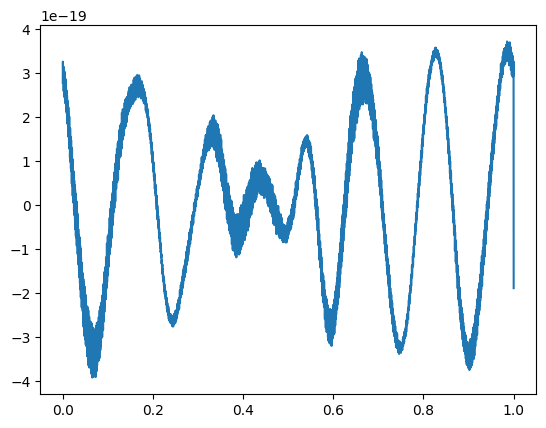

In [101]:
generated_noise[0:1].plot()

In [105]:
GN.S11.shape
GN.cholesky.shape

(4096, 4096)

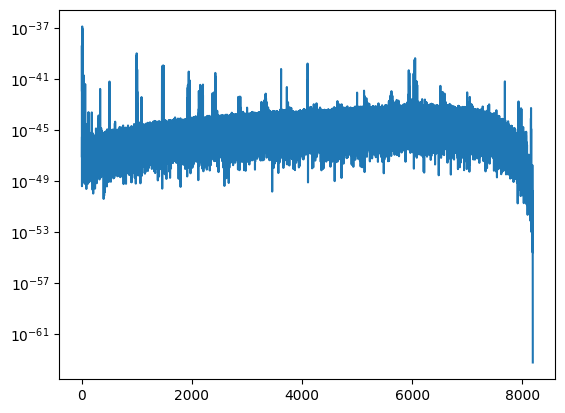

In [110]:
h1.get_psd(nperseg=len(h1)).plot()
plt.yscale('log')

In [116]:
h1_psd = h1.get_psd(nperseg=len(h1))
h1_psd

0.00000       1.243634e-42
0.03125       5.682887e-41
0.06250       1.308641e-39
0.09375       3.992887e-39
0.12500       2.536232e-39
                  ...     
8191.87500    6.380802e-59
8191.90625    7.415491e-60
8191.93750    2.444705e-61
8191.96875    2.404370e-62
8192.00000    5.923616e-64
Length: 262145, dtype: float64

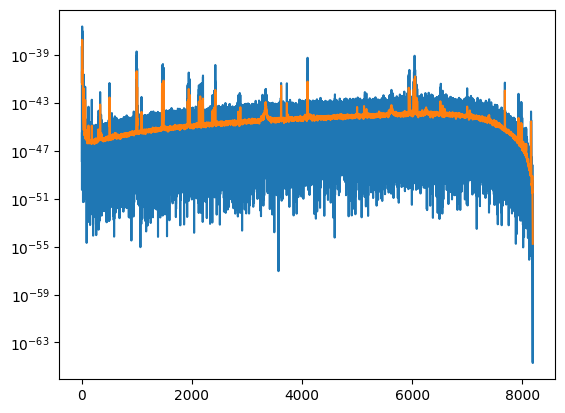

In [189]:
white_noise = ringdown.Data(np.random.normal(0,1,len(h1_psd)), index=h1_psd.index)
h1_colored_noise = white_noise * np.sqrt(h1_psd)
(h1_colored_noise.abs()**2).plot()
h1.get_psd(nperseg=h1.fsamp).plot()
plt.yscale('log')

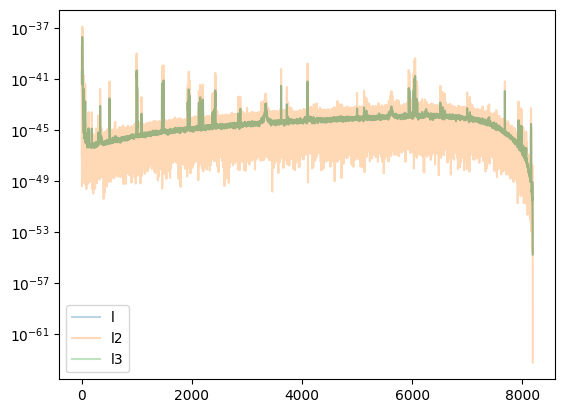

In [199]:
l = h1.get_psd(nperseg=h1.fsamp)
l2 = h1.get_psd(nperseg=len(h1))
l3 = l.interpolate_to_index(l2.index, kind='linear')

l.plot(label='l', alpha=0.3)
l2.plot(label='l2', alpha=0.3)
l3.plot(label='l3', alpha=0.3)
plt.yscale('log')
plt.legend()
plt.show()

In [386]:
def create_noise_like(noise_sample : ringdown.Data,
                      nperseg = None):
    
    # First get a nice psd estimate up to a freq
    nperseg = nperseg or noise_sample.fsamp  # Down to 1Hz
    noise_nice_psd = noise_sample.get_psd(nperseg=nperseg)
    
    new_freq_index = noise_sample.get_psd(nperseg=len(noise_sample)).index
    
    noise_nice_interpolated = noise_nice_psd.interpolate_to_index(new_freq_index)
    
    
    white_noise_real_FD = ringdown.Data(np.random.normal(0,1,len(new_freq_index)), 
                                index = new_freq_index)
    
    white_noise_imag_FD = ringdown.Data(np.random.normal(0,1,len(new_freq_index)), 
                                index = new_freq_index)
    
    colored_noise_real_FD = white_noise_real_FD * noise_nice_interpolated.apply(np.sqrt) * np.sqrt(1/2)
    colored_noise_imag_FD = white_noise_imag_FD * noise_nice_interpolated.apply(np.sqrt) * np.sqrt(1/2)

    return colored_noise_real_FD + 1j*colored_noise_imag_FD
    
create_noise_like(h1)

0.00000      -3.249306e-21-1.494754e-21j
0.03125       1.159659e-20-1.332916e-22j
0.06250       2.018532e-22-6.925703e-21j
0.09375      -6.425217e-21-1.067678e-20j
0.12500       1.076300e-21-2.374250e-22j
                         ...            
8191.87500   -6.009016e-28+7.285066e-28j
8191.90625    1.695205e-28-6.644169e-28j
8191.93750   -7.927027e-29+5.335589e-28j
8191.96875   -5.870981e-28+5.031521e-28j
8192.00000    9.453733e-29+5.526674e-29j
Length: 262145, dtype: complex128

In [142]:
mydata = ringdown.Data(np.random.normal(0,1,2**14), index=np.linspace(0,1,2**14))

In [200]:
l

0.0       3.495097e-41
1.0       1.963282e-41
2.0       3.763265e-42
3.0       4.581035e-41
4.0       2.229447e-40
              ...     
8188.0    1.921336e-52
8189.0    6.062170e-53
8190.0    1.835996e-53
8191.0    4.647509e-54
8192.0    1.733467e-55
Length: 8193, dtype: float64

In [405]:
from scipy.fft import fft, fftfreq
import pandas as pd
import scipy

N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]


def fourier_transform_new_noise(noise):
    N = len(noise)
    T = noise.index[1] - noise.index[0]
    
    x = noise.index
    y = noise.values
    
    yf = scipy.fft.fft(y)
    xf = 1j*scipy.fft.fftfreq(N, T)[:N//2]
    xf
    newx = scipy.fft.ifft(yf)
    
    return ringdown.FrequencySeries(yf[:N//2], index=xf), newx

def fourier_transform(noise):
    N = len(noise)
    T = noise.index[1] - noise.index[0]
    
    x = noise.index
    y = noise.values
    
    yf = scipy.fft.fft(y)
    xf = scipy.fft.fftfreq(N, T)[:N//2]
    
    return ringdown.FrequencySeries(yf[:N//2], index=xf)

new_s = fourier_transform(pd.Series(np.random.normal(0,1,2**16), index=np.linspace(0,1,2**16)))
#plt.hist(np.arctan2(np.imag(new_s),np.real(new_s)))
xx = pd.Series(np.random.normal(0,1,2**16), index=np.linspace(0,1,2**16))
a,b = fourier_transform_new(xx)



a


0.000000        -47.2157870-0.0000000j
0.999985        238.116439-239.195092j
1.999969       -20.3913180-44.0579990j
2.999954        34.9035210+59.1043940j
3.999939       -84.3695640+79.3424630j
                         ...          
32762.500076     20.6073380+8.1288440j
32763.500061    -16.326812-362.283725j
32764.500046     11.866919-245.272496j
32765.500031   -20.9927770-90.3424840j
32766.500015     67.055046+201.284772j
Length: 32768, dtype: complex128

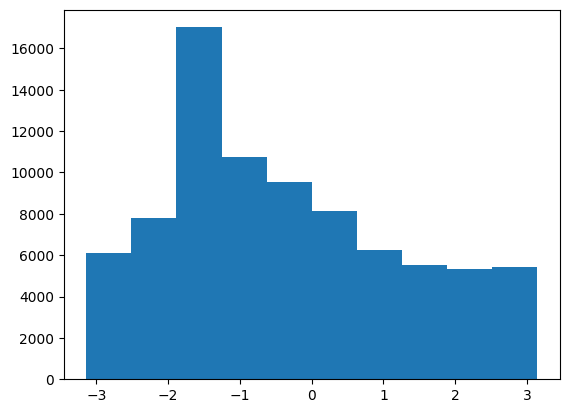

In [381]:
thestrain = event.strain()["H1"]

i = 0
new_s = fourier_transform(thestrain[(thestrain.index[0] + i):(thestrain.index[0] + i +10)])
plt.hist(np.arctan2(np.imag(new_s),np.real(new_s)))
plt.show()

(-1e-16, 1e-16)

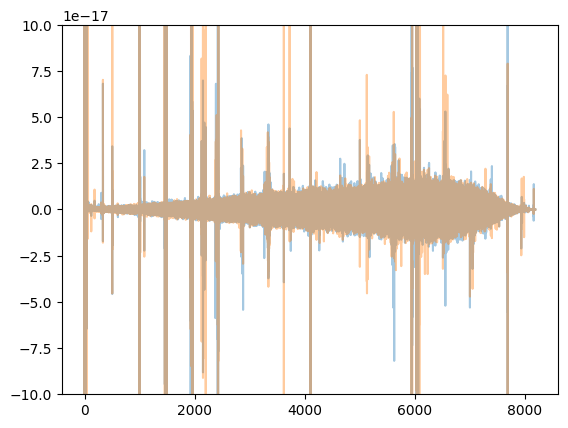

In [360]:
plt.plot(fourier_transform(h1).apply(np.imag), label="Imag", alpha=0.4)
plt.plot(fourier_transform(h1).apply(np.real), label="Real", alpha=0.4)
plt.ylim((-1e-16, 1e-16))
#plt.yscale('log')

<AxesSubplot: >

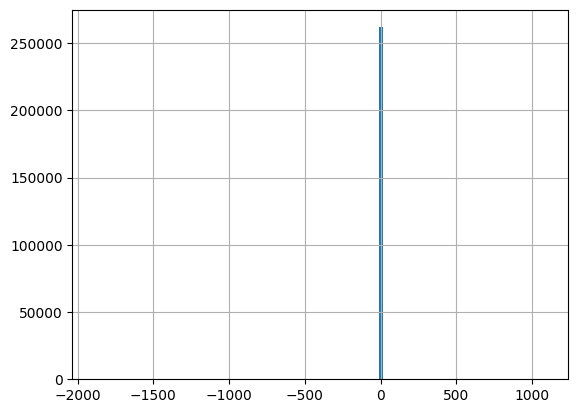

In [346]:
(fourier_transform(h1).apply(np.real)*(1e17)).hist(bins=100)

In [349]:
fourier_transform(h1).apply(np.real)*(1e17)

0.00000        -1.979728
0.03125        12.658633
0.06250        96.630571
0.09375      -344.938072
0.12500       216.024968
                 ...    
8191.84375     -0.001261
8191.87500     -0.001261
8191.90625     -0.001261
8191.93750     -0.001261
8191.96875     -0.001261
Length: 262144, dtype: float64

In [327]:
scipy.fft.fftfreq(len(h1), 32).max()

0.015624940395355225

In [534]:
noise = ringdown.Data(np.random.normal(0,1,2**16), index=np.linspace(0,1,2**16))

In [548]:
def make_new_noise(noise):
    N = len(noise)
    dt = noise.index[1] - noise.index[0]

    x = noise.index
    y = noise.values

    yf = scipy.fft.fft(y)
    phase = np.copy(yf)

    phase[0] = 1
    phase[1:(N//2)] = np.exp( 1j*2*np.pi*np.random.rand(len(yf[1:N//2])) )
    phase[N//2] = 1
    phase[((N//2)+1):] = np.conjugate(np.flip(phase[1:(N//2)]))

    new_noise = scipy.fft.ifft(phase*yf)

    new_noise = ringdown.Data(new_noise.real, index=x)
    
    return new_noise

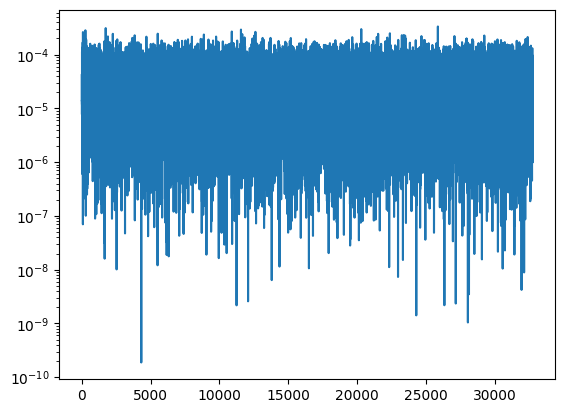

In [547]:
new_noise.get_psd().plot()
plt.yscale('log')

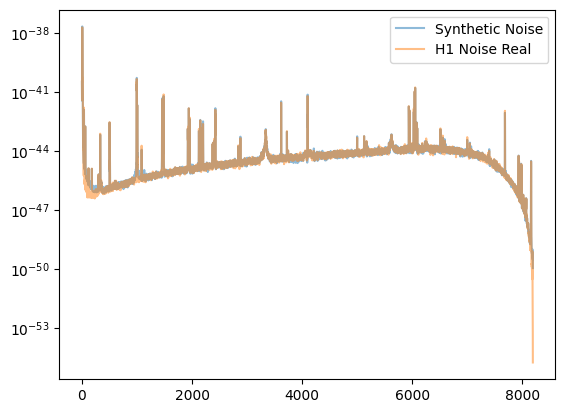

In [566]:
make_new_noise(h1).get_psd().plot(label='Synthetic Noise', alpha=0.5)
h1.get_psd().plot(label='H1 Noise Real', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()